# Activate GPU and install fast.ai

In [1]:
#Change runtime to GPU by clicking "Runtime">"Change Runtime type">"Hardware accelerator">"GPU"

In [2]:
#Test if GPU running
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

ModuleNotFoundError: No module named 'tensorflow'

In [3]:
!curl -s https://course.fast.ai/setup/colab | bash

mkdir: cannot create directory ‘/root’: Permission denied
mkdir: cannot create directory ‘/root’: Permission denied
ln: failed to create symbolic link '/content': Permission denied
ln: failed to create symbolic link '/content': Permission denied
Updating fastai...
Done.


# IMPORT REQUIRED MODELS

In [1]:
import fastai
from fastai import *
from fastai.text import * 
from fastai.text.models import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix, accuracy_score

import nltk
from nltk.corpus import stopwords
import re 
from bs4 import BeautifulSoup

from nltk.stem.snowball import SnowballStemmer

# Prepare data

In [2]:
# Not excluding stopwords as it performs better
stops={}

In [3]:
#PREPROCEESING THE TEXT

def text_preprocessing(text, language, minWordSize):
    
    # remove html
    text_html = BeautifulSoup(text,"html.parser" ).get_text()
    
    # remove non-letters
    text_non_letters = re.sub("[^a-zA-Z']", " ", text_html) 
        
    # convert to lower-case
    text_lower = text_non_letters.lower()
    
    # remove stop words
    text_no_stop_words = ' '
    for w in text_lower.split():
        if w not in stops:  
            text_no_stop_words = text_no_stop_words + w + ' '  
    
    # do stemming
    text_stemmer = ' '
    stemmer = SnowballStemmer(language)
    for w in text_no_stop_words.split():
        text_stemmer = text_stemmer + stemmer.stem(w) + ' '
         
    # remove short words
    text_no_short_words = ' '
    for w in text_stemmer.split(): 
        if len(w) >=minWordSize:
            text_no_short_words = text_no_short_words + w + ' '
    return text_no_short_words

In [7]:
#Connect to google drive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"


ModuleNotFoundError: No module named 'google'

In [4]:
# Upload newdata.csv
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

ModuleNotFoundError: No module named 'google'

In [5]:
#load and prepare new data
newdata=pd.read_csv('Input_data/newdata.csv')
sentiment_new = newdata['Sentiment'].values

#Filter only English
newdata=newdata[newdata['Language']=="eng"]


In [6]:
# Preprocess

#reviews and sentiment as values
reviews_new= newdata['Text'].values
sentiment_new = newdata['Sentiment'].values

#test train split
reviews_train, reviews_test, sentiment_train, sentiment_test = train_test_split(reviews_new, sentiment_new, test_size=0.4,random_state=0,stratify=sentiment_new)

#bag of words
language = 'english'
minWordLength = 2 # shorter words will be removed

for i in range(len(reviews_train)):
    reviews_train[i] = text_preprocessing(reviews_train[i], language, minWordLength)
for i in range(len(reviews_test)):
    reviews_test[i] = text_preprocessing(reviews_test[i], language, minWordLength)
        

/home/arul/anaconda3/envs/ath/lib/python3.7/site-packages/bs4/__init__.py:389: UserWarning: "https://www.valkyriestudios.be" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


# Create and train models

In [7]:
# Create language databunch with tokens
data_lm = TextLMDataBunch.from_df(train_df = pd.DataFrame({'text': reviews_train, 'labels': sentiment_train}), 
                                  valid_df = pd.DataFrame({'text': reviews_test, 'labels':sentiment_test}), 
                                  path = "",
                                 text_cols=0,
                                 label_cols=1)


In [8]:
data_lm.show_batch()

idx,text
0,had love meal oliv garlic bread xxunk di mozzarella capres salad spaghetti bolognes spaghetti di pomodoro vitello di limon everyth was veri good especi the spaghetti the servic was excel we left xxunk and happi xxbos of cours xxbos veri friend servic and care about guest who was xxunk also great food and american atmospher xxbos the servic was excel warm and friend staff the food was good and there
1,xxunk it in citi with sooo mani great option this is an xxunk fault and the place does n't deserv visit xxbos nice salat nice stuff great place xxbos book on line as was look for pre gig not too expens meal on arriv was show prompt to my tabl drink order was taken and bottl of water left for me was not pressur to place my order order from
2,must for everyon xxbos veri rude staff it veri annoy that you have to pay servic charg for their rude all of their staff were rude even the food qualiti was horribl we had spaghetti carbonara and the cream was veri sticki would definit not recommend this place xxbos we went here for the first time and found this caf restaur pleasant surpris xxunk and xxunk clean the best coffe
3,websit feedback regard food deliveri or restaur visit are best to send at info bavet eu talk soon http www bavet eu xxbos order at it took hour for the order to be prepar and in the end it was cancel becaus there weren ani deliveroo rider still ride at pm no surpris there pita it is xxbos we stop here for quick dinner befor the xxunk xxunk concert conveni
4,in fact half of normal size fillet and xxunk the desert sticki toffe pud was the size of tooth pick xxbos good burger and friend staff xxbos tr bon xxunk xxunk tr bien mang xxbos super thank xxbos pass this place mani time and thought we would give it tri great valu cours staff attent but not hang around behind you probabl would n't park at the front next time


In [9]:
# Vocabulary - First 20 unique tokens
data_lm.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 'and',
 'was',
 'to',
 'we',
 'for',
 'of',
 'it',
 'food',
 'in',
 'is']

In [10]:
# Replacing tokens with numbers
data_lm.train_ds[0][0].data[:10]

array([  2, 321,  50, 138, 614,  10,  50, 205, 507, 191])

In [11]:
# Load pre-trained (Wikipedia) model, which predicts the next word
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=True, drop_mult=0.5);

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


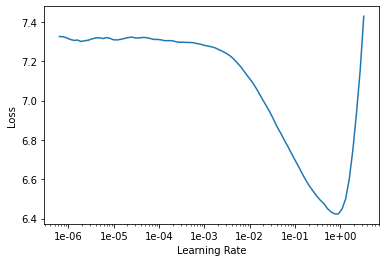

In [13]:
learn.recorder.plot()

In [14]:
# Train learn object with learning rate: 1e-2
# Run this twice
learn.fit_one_cycle(1, 1e-1)
learn.save_encoder('fit_encoder')


epoch,train_loss,valid_loss,accuracy,time
0,5.626366,4.969378,0.171922,00:06


In [15]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.613068,4.593090,0.201175,00:07


In [16]:
learn.unfreeze()
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.138971,4.544988,0.208882,00:07
1,4.017347,4.555936,0.209551,00:07


In [17]:
learn.unfreeze()
learn.fit_one_cycle(2, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,3.917330,4.551407,0.210127,00:07
1,3.900906,4.549543,0.210397,00:07


In [18]:
learn.unfreeze()
learn.fit_one_cycle(2, 1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,3.905201,4.550066,0.210468,00:07
1,3.888722,4.549727,0.210585,00:07


In [19]:
learn.unfreeze()
learn.fit_one_cycle(2, 1e-6)

epoch,train_loss,valid_loss,accuracy,time
0,3.885784,4.549590,0.210538,00:07
1,3.889218,4.550256,0.210385,00:07


In [20]:
learn.predict("The review is:",n_words=10)


'The review is: game tutto final five star from the earth and crema'

In [21]:
learn.save_encoder('fit_encoder')

In [39]:
# Create classifier databunch
data_class = TextClasDataBunch.from_df(path="",train_df = pd.DataFrame({'text': reviews_train, 'labels': sentiment_train}),
                                    valid_df = pd.DataFrame({'text': reviews_test, 'labels':sentiment_test}),
                                    vocab=data_lm.train_ds.vocab, bs=32,
                                      text_cols=0,
                                      label_cols=1)


In [40]:
# Now build a classifier with fine tuned encoder
classifier = text_classifier_learner(data_class, AWD_LSTM, drop_mult=0.3)

In [41]:
classifier.load_encoder('fit_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (2957 items)
x: TextList
xxbos such love coffe shop and love two ladi work there with their love dog had great time would love to visit them again,xxbos lekker uniek pasta maar niet de xxunk,xxbos aw servic wait almost an hour for two burger becaus they forgot we were there and what we order,xxbos pasta la xxunk babi xxunk xxunk xxunk bavet ghent xxunk gent spaghetti foodporn food belgianblogg,xxbos we had love meal oliv garlic bread xxunk di mozzarella capres salad spaghetti bolognes spaghetti di pomodoro vitello di limon everyth was veri good especi the spaghetti the servic was excel we left xxunk and happi
y: CategoryList
1,0,-1,1,1
Path: .;

Valid: LabelList (1972 items)
x: TextList
xxbos my guest was vegan and the waitress was so help in figur out what could be had from the menu my guest end up get veget sandwich which she said was delici had the chicken and asparagus pasta definet go for the larg size it big portion xxunk to fi

In [32]:
classifier.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


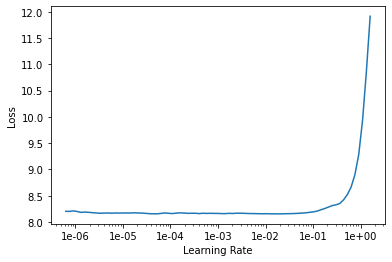

In [33]:
classifier.recorder.plot()

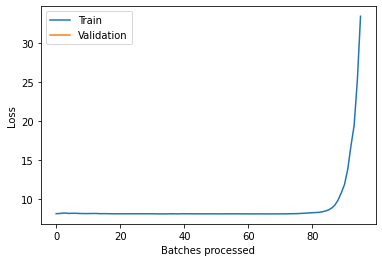

In [34]:
classifier.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-03
Min loss divided by 10: 3.02E-02


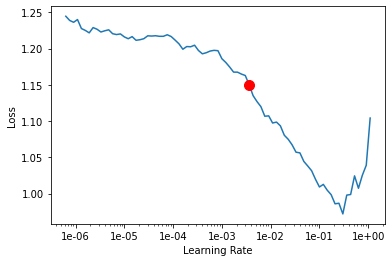

In [42]:
classifier.freeze_to(-2)
classifier.lr_find()
classifier.recorder.plot(suggestion=True)

In [43]:
classifier.fit_one_cycle(2, 1.5e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.580972,0.366886,0.871197,00:13
1,0.386208,0.343487,0.878296,00:12


In [28]:
# Fit model 
classifier.unfreeze()
classifier.fit_one_cycle(1, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,9.617637,8.912232,0.186047,00:02


In [29]:
# Fit model again
# Run this twice - same with 1e-1, 1e-3
classifier.unfreeze()
classifier.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,9.274076,7.253069,0.186047,00:02


In [379]:
classifier.predict("is")


(Category  do like the classi smooth leather seat the servic is out of and the qualiti of my meal guest or busi event are well worth the price do recommend the strawberri dacr brambl cocktail serv up with lobster surf turf ,
 tensor(404),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]))

In [372]:
classifier.predict("was")

(Category  great coffe veri nice atmospher and chill out pleas ,
 tensor(826),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]))